In [ ]:
#!/usr/bin/env python3
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pathlib import Path
import logging
import os
from sklearn import svm
from sklearn.linear_model import Perceptron, LogisticRegression, SGDClassifier
from sklearn import model_selection
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV
from sklearn import metrics
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SequentialFeatureSelector



import pickle


In [16]:

# logger.info("-------------------------------------------------------------------------")
# region init
cwd_path = Path(".")
test_data_path = cwd_path / Path("test.csv")
train_data_path = cwd_path / Path("train.csv")
pairplot_file = "pairplot.png"
pairplot_PCA_file = "pairplot_PCA.png"
random_state = 42
grid_search_cv_file = 'grid_search_cv.pkl'
grid_search_cv_path = cwd_path / Path(grid_search_cv_file)
kaggle_path = cwd_path / Path("kaggle_submition.csv")
# endregion 


In [17]:

# region reading from file
# logger.info("reding training file")
df_train = pd.read_csv(train_data_path).drop(["obj_ID", "run_ID", "rerun_ID", "cam_col", "field_ID", "spec_obj_ID", "plate", "MJD", "fiber_ID"], axis=1)
df_train["class"] = df_train["class"].map({"GALAXY": 0, "QSO": 1, "STAR": 2})
# logger.info("remapping of class data {\"GALAXY\": 0, \"QSO\": 1, \"STAR\": 2}")
# logger.info("reding test file")
df_test = pd.read_csv(test_data_path).drop(["obj_ID", "run_ID", "rerun_ID", "cam_col", "field_ID", "spec_obj_ID", "plate", "MJD", "fiber_ID"], axis=1)

# df_nan_values = df_train[df_train.isna().any(axis=1)]
# print(len(df_nan_values))
# endregion 


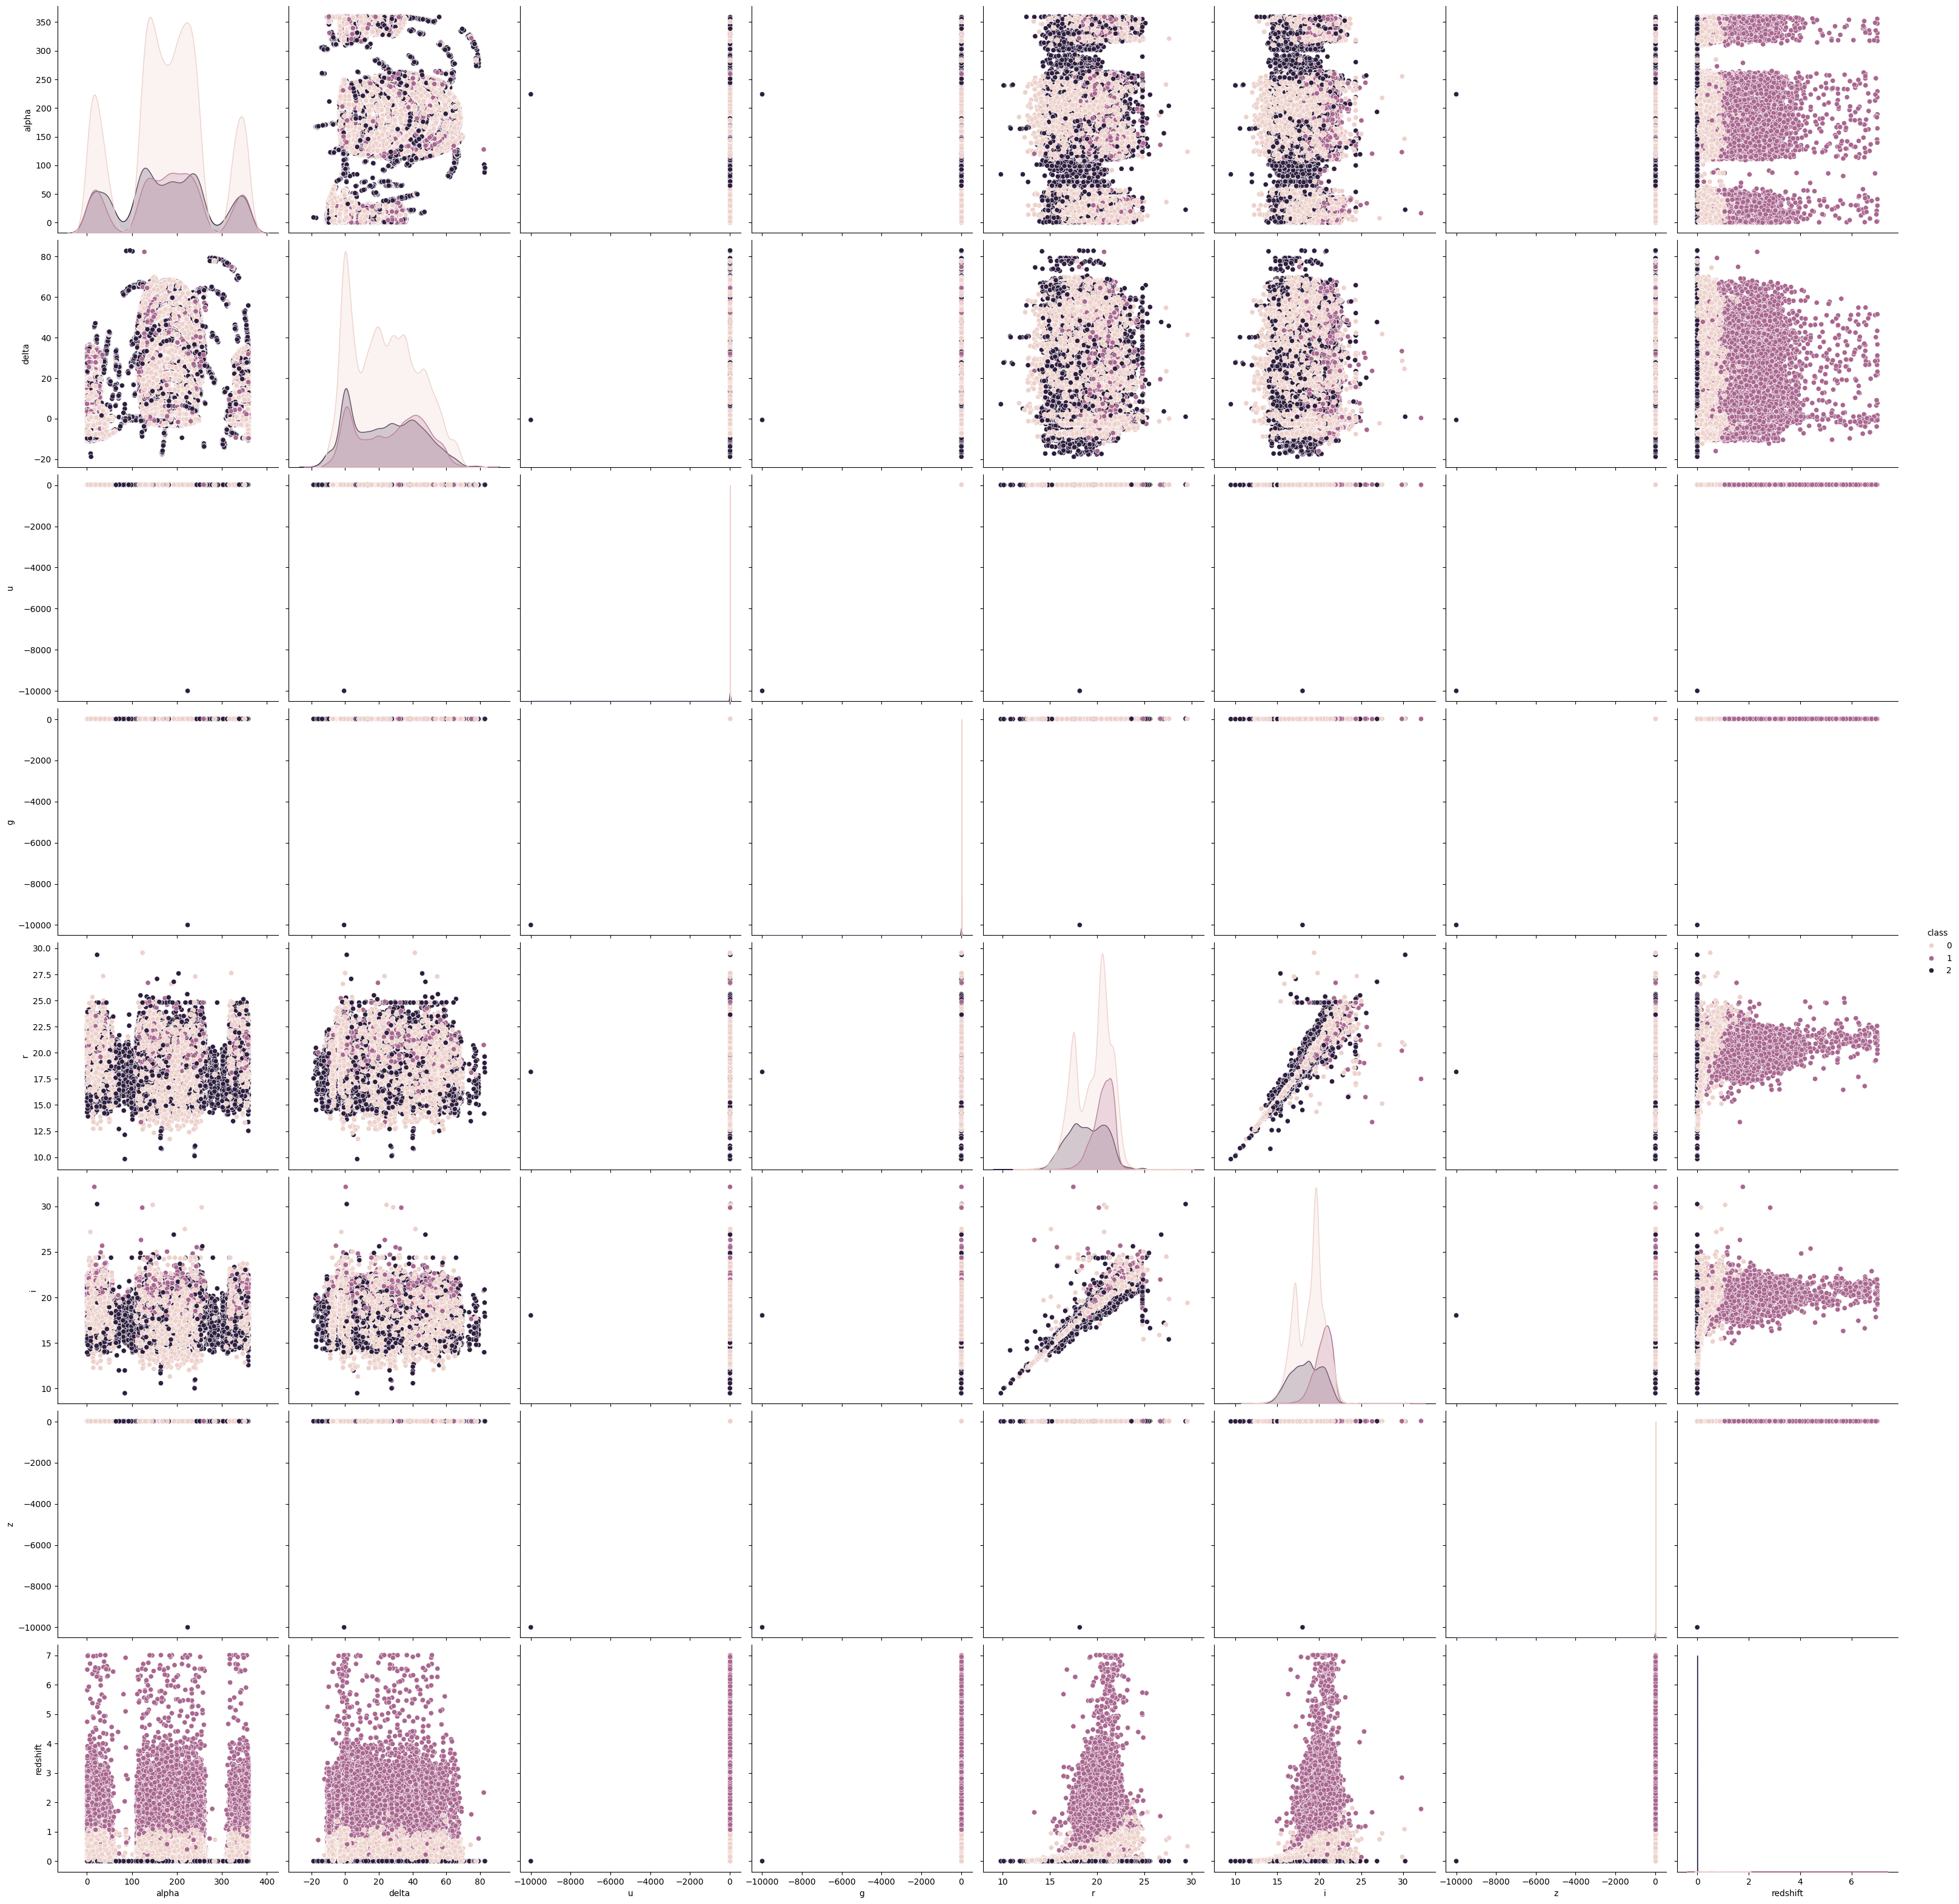

In [6]:

# region pairplot

# logger.info("plotting pairplot")
pairplot = sns.pairplot(df_train, hue="class", height=4.0)
pairplot
# logger.info("saving plot to file %s", pairplot_file)
# pairplot.savefig(cwd_path / Path(pairplot_file))
# plt.clf()



[9.29945774e+03 3.79178861e+03 3.78501641e+02 6.57208479e+00
 1.99730697e+00 4.09759761e-01 3.29058027e-01 4.61861051e-02]


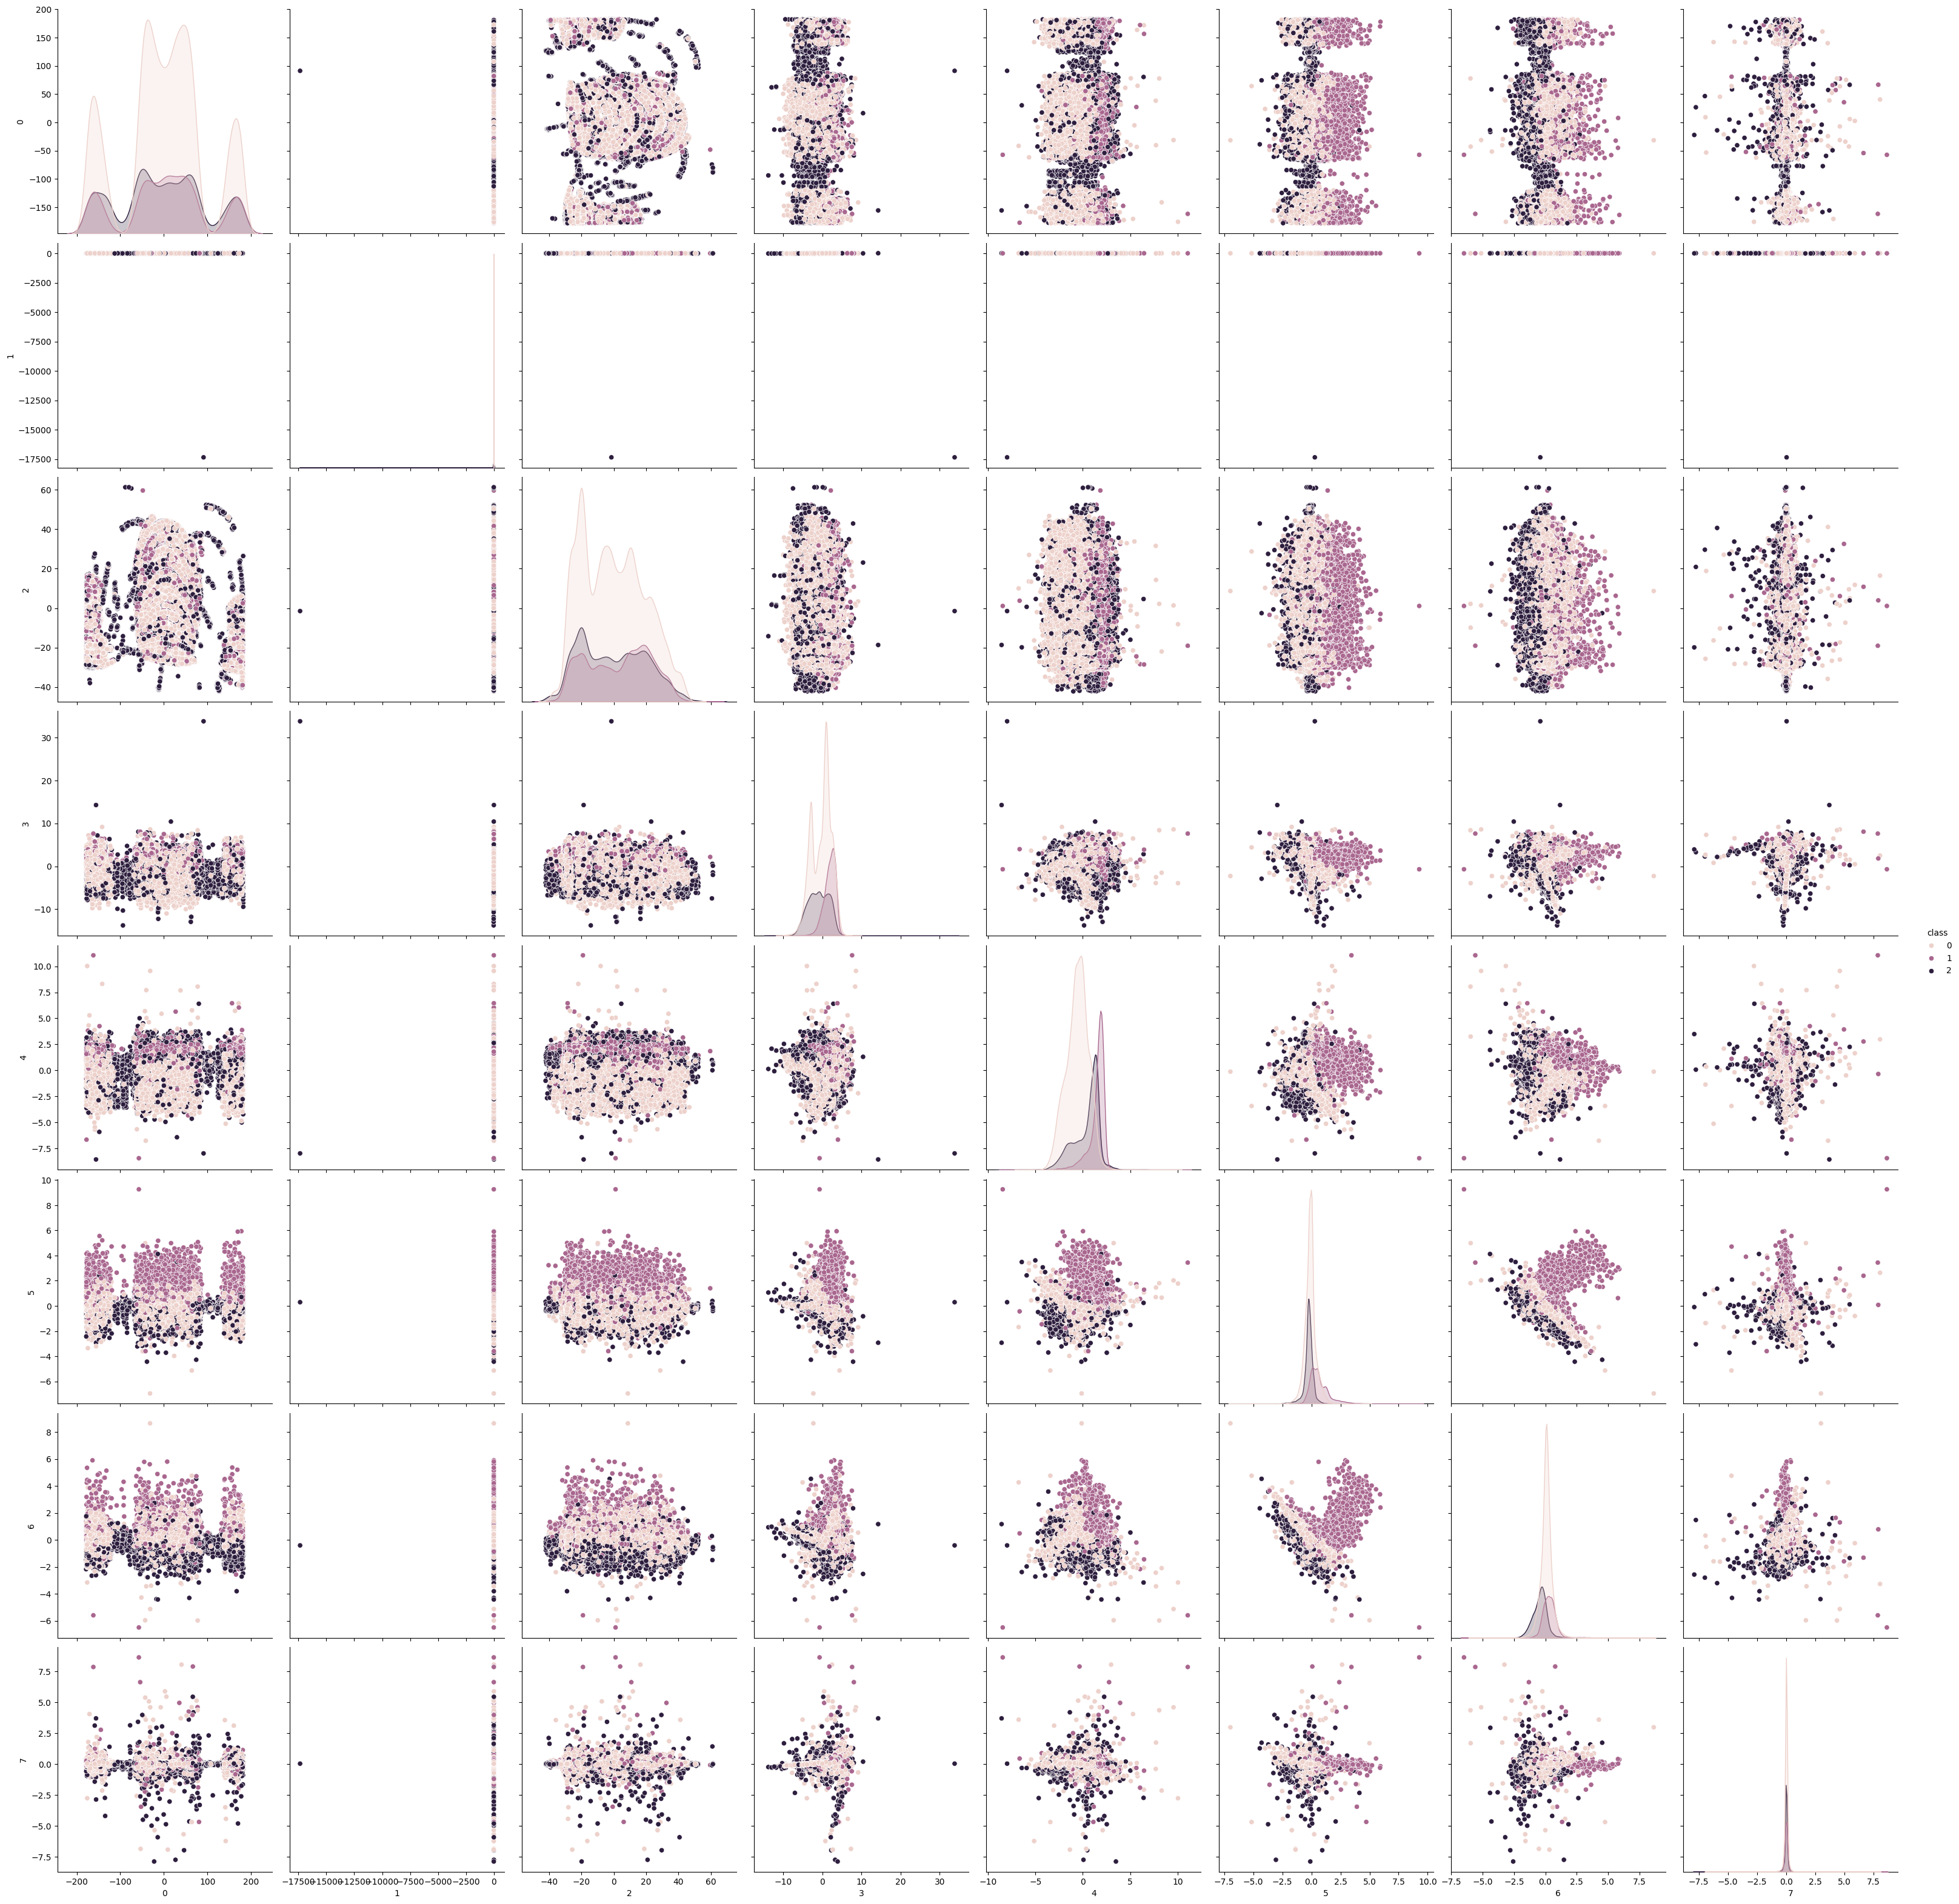

In [7]:


pca = PCA()
df_pca = pd.DataFrame(pca.fit_transform(df_train.drop("class", axis=1).dropna().to_numpy()))
print(pca.explained_variance_)
explained_variance = str(pca.explained_variance_)
# logger.info("explained_variance %s", explained_variance)

# logger.info("plotting pairplot PCA")
df_pca["class"] = df_train.dropna()["class"].to_numpy()
pairplot = sns.pairplot(df_pca, hue="class", height=4.0)
pairplot
# logger.info("saving plot to file %s", pairplot_PCA_file)
# pairplot.savefig(cwd_path / Path(pairplot_PCA_file))
# plt.clf()


# endregion 


In [18]:

# region exstracting data as nupy array
# logger.info("converting to numpy array")

train_np_array = df_train.fillna(df_train.mean()).drop("class", axis=1).to_numpy()
train_class_np_array = df_train.fillna(df_train.mean())["class"].to_numpy()
test_np_array = df_test.fillna(df_train.mean()).to_numpy()
# endregion 


In [19]:

# region spliting data for training
# logger.info("splitting X_train_standardized for training")

# # used for redusing the train size when first starting the task 
# train_test_split =  model_selection.train_test_split(
#     train_np_array, 
#     train_class_np_array, 
#     test_size=0.9, 
#     random_state=random_state
# )

# x_train, x_test, y_train, y_test =  train_test_split

x_train, y_train = (train_np_array, train_class_np_array)
# endregion 


In [20]:

# region setting upp a pipeline
# logger.info("creating pipeline")
pipeline = Pipeline([
    ('scaling',             StandardScaler()),
    ('preprocessoer',   PCA(n_components=5)),
    ('classifier',          svm.SVC())
])
# endregion 


In [21]:

# region setting upp grid search
if os.path.isfile(grid_search_cv_path):
    # logger.info("found grid_search_cv file. loading from file.")
    with open(grid_search_cv_path, 'rb') as f:
        grid_search_cv = pickle.load(f)
else:
    # logger.info("creating grid search")
    # logger.info("setting upp parameters")
    param_SVC_C = np.logspace(-1,2.8,25).tolist()
    param_RFC_n_estimator = np.linspace(10, 50,10).astype(int).tolist()
    param_RFC_max_depth = np.linspace(2, 50, 10).astype(int).tolist()
    param_KNN_n_neighbors = np.linspace(2, 10, 8).astype(int).tolist()

    pca = PCA(n_components=6)
    lda = LinearDiscriminantAnalysis()
    sfs = SequentialFeatureSelector(LogisticRegression())
    preprocessoer = [pca, lda]

    param_grid = [
        {
            'preprocessoer': preprocessoer,
            'classifier': [svm.SVC()],
            'classifier__C': param_SVC_C,
            'classifier__kernel': ['rbf', 'poly'],
        },
        {
            'preprocessoer': preprocessoer,
            'classifier': [RandomForestClassifier()],
            'classifier__n_estimators': param_RFC_n_estimator,
            'classifier__max_depth': param_RFC_max_depth
        },
        {
            'preprocessoer': preprocessoer,
            'classifier': [LogisticRegression()],
            'classifier__C': param_SVC_C,
            'classifier__solver': ['lbfgs', 'newton-cg', 'newton-cholesky'],
        },
        {
            'preprocessoer': preprocessoer,
            'classifier': [KNeighborsClassifier()],
            'classifier__n_neighbors': param_KNN_n_neighbors,
        }
    ]

    # logger.info("defining grid search using param_grid")
    grid_search_cv = GridSearchCV(
        estimator=pipeline,
        param_grid=param_grid,
        cv=5,
        n_jobs=-1,
        verbose=3
    )

    # logger.info("fitting grid search to training set. this might take a long time")
    grid_search_cv.fit(x_train, y_train)
    # logger.info("dumping grid_search_cv to pickle file")
    with open(grid_search_cv_path, 'wb') as f:
        pickle.dump(grid_search_cv, f)



Fitting 5 folds for each of 466 candidates, totalling 2330 fits
[CV 1/5] END classifier=SVC(), classifier__C=0.1, classifier__kernel=rbf, preprocessoer=LinearDiscriminantAnalysis();, score=0.916 total time=  49.6s
[CV 3/5] END classifier=SVC(), classifier__C=0.1, classifier__kernel=rbf, preprocessoer=LinearDiscriminantAnalysis();, score=0.926 total time=  50.3s
[CV 4/5] END classifier=SVC(), classifier__C=0.1, classifier__kernel=rbf, preprocessoer=LinearDiscriminantAnalysis();, score=0.932 total time=  51.4s
[CV 5/5] END classifier=SVC(), classifier__C=0.1, classifier__kernel=rbf, preprocessoer=LinearDiscriminantAnalysis();, score=0.922 total time=  53.1s
[CV 2/5] END classifier=SVC(), classifier__C=0.1, classifier__kernel=rbf, preprocessoer=LinearDiscriminantAnalysis();, score=0.920 total time=  53.6s
[CV 1/5] END classifier=SVC(), classifier__C=0.1, classifier__kernel=poly, preprocessoer=LinearDiscriminantAnalysis();, score=0.909 total time=  53.3s
[CV 2/5] END classifier=SVC(), clas

/media/oystein/Server/Server/Master/Vår 2025/DAT200-1 25V Anvendt maskinlæring/ca/ca_4/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 5/5] END classifier=LogisticRegression(), classifier__C=0.6189658188912605, classifier__solver=lbfgs, preprocessoer=PCA(n_components=6);, score=0.951 total time=   1.8s
[CV 1/5] END classifier=LogisticRegression(), classifier__C=0.6189658188912605, classifier__solver=newton-cg, preprocessoer=LinearDiscriminantAnalysis();, score=0.907 total time=   0.5s
[CV 4/5] END classifier=LogisticRegression(), classifier__C=0.6189658188912605, classifier__solver=newton-cg, preprocessoer=PCA(n_components=6);, score=0.956 total time=   1.4s
[CV 3/5] END classifier=LogisticRegression(), classifier__C=0.6189658188912605, classifier__solver=newton-cg, preprocessoer=PCA(n_components=6);, score=0.951 total time=   1.6s
[CV 2/5] END classifier=LogisticRegression(), classifier__C=0.6189658188912605, classifier__solver=newton-cg, preprocessoer=LinearDiscriminantAnalysis();, score=0.915 total time=   0.6s
[CV 4/5] END classifier=LogisticRegression(), classifier__C=0.6189658188912605, classifier__solver=ne

/media/oystein/Server/Server/Master/Vår 2025/DAT200-1 25V Anvendt maskinlæring/ca/ca_4/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 1/5] END classifier=LogisticRegression(), classifier__C=0.8912509381337455, classifier__solver=lbfgs, preprocessoer=PCA(n_components=6);, score=0.951 total time=   2.0s
[CV 1/5] END classifier=LogisticRegression(), classifier__C=0.8912509381337455, classifier__solver=newton-cg, preprocessoer=LinearDiscriminantAnalysis();, score=0.907 total time=   0.5s
[CV 1/5] END classifier=LogisticRegression(), classifier__C=0.8912509381337455, classifier__solver=newton-cg, preprocessoer=PCA(n_components=6);, score=0.951 total time=   1.9s
[CV 2/5] END classifier=LogisticRegression(), classifier__C=0.8912509381337455, classifier__solver=newton-cg, preprocessoer=LinearDiscriminantAnalysis();, score=0.915 total time=   0.6s
[CV 4/5] END classifier=LogisticRegression(), classifier__C=0.8912509381337455, classifier__solver=newton-cg, preprocessoer=PCA(n_components=6);, score=0.957 total time=   1.6s
[CV 3/5] END classifier=LogisticRegression(), classifier__C=0.8912509381337455, classifier__solver=ne

/media/oystein/Server/Server/Master/Vår 2025/DAT200-1 25V Anvendt maskinlæring/ca/ca_4/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 5/5] END classifier=LogisticRegression(), classifier__C=1.2833151855576512, classifier__solver=lbfgs, preprocessoer=PCA(n_components=6);, score=0.953 total time=   1.4s
[CV 1/5] END classifier=LogisticRegression(), classifier__C=1.2833151855576512, classifier__solver=newton-cg, preprocessoer=LinearDiscriminantAnalysis();, score=0.907 total time=   0.5s
[CV 1/5] END classifier=LogisticRegression(), classifier__C=1.2833151855576512, classifier__solver=newton-cg, preprocessoer=PCA(n_components=6);, score=0.953 total time=   1.4s
[CV 4/5] END classifier=LogisticRegression(), classifier__C=1.2833151855576512, classifier__solver=newton-cg, preprocessoer=PCA(n_components=6);, score=0.957 total time=   1.3s
[CV 2/5] END classifier=LogisticRegression(), classifier__C=1.2833151855576512, classifier__solver=newton-cg, preprocessoer=LinearDiscriminantAnalysis();, score=0.915 total time=   0.6s
[CV 3/5] END classifier=LogisticRegression(), classifier__C=1.2833151855576512, classifier__solver=ne

/media/oystein/Server/Server/Master/Vår 2025/DAT200-1 25V Anvendt maskinlæring/ca/ca_4/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/media/oystein/Server/Server/Master/Vår 2025/DAT200-1 25V Anvendt maskinlæring/ca/ca_4/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Plea

[CV 3/5] END classifier=LogisticRegression(), classifier__C=2.6607250597988084, classifier__solver=lbfgs, preprocessoer=PCA(n_components=6);, score=0.955 total time=   1.8s
[CV 1/5] END classifier=LogisticRegression(), classifier__C=2.6607250597988084, classifier__solver=lbfgs, preprocessoer=PCA(n_components=6);, score=0.955 total time=   1.9s


/media/oystein/Server/Server/Master/Vår 2025/DAT200-1 25V Anvendt maskinlæring/ca/ca_4/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 5/5] END classifier=LogisticRegression(), classifier__C=2.6607250597988084, classifier__solver=lbfgs, preprocessoer=PCA(n_components=6);, score=0.955 total time=   1.9s
[CV 1/5] END classifier=LogisticRegression(), classifier__C=2.6607250597988084, classifier__solver=newton-cg, preprocessoer=LinearDiscriminantAnalysis();, score=0.907 total time=   0.6s
[CV 3/5] END classifier=LogisticRegression(), classifier__C=2.6607250597988084, classifier__solver=newton-cg, preprocessoer=PCA(n_components=6);, score=0.955 total time=   1.6s
[CV 1/5] END classifier=LogisticRegression(), classifier__C=2.6607250597988084, classifier__solver=newton-cg, preprocessoer=PCA(n_components=6);, score=0.955 total time=   1.7s
[CV 4/5] END classifier=LogisticRegression(), classifier__C=2.6607250597988084, classifier__solver=newton-cg, preprocessoer=PCA(n_components=6);, score=0.958 total time=   1.3s
[CV 2/5] END classifier=LogisticRegression(), classifier__C=2.6607250597988084, classifier__solver=newton-cg, 

/media/oystein/Server/Server/Master/Vår 2025/DAT200-1 25V Anvendt maskinlæring/ca/ca_4/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/media/oystein/Server/Server/Master/Vår 2025/DAT200-1 25V Anvendt maskinlæring/ca/ca_4/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Plea

[CV 5/5] END classifier=LogisticRegression(), classifier__C=3.831186849557287, classifier__solver=lbfgs, preprocessoer=PCA(n_components=6);, score=0.956 total time=   1.3s
[CV 1/5] END classifier=LogisticRegression(), classifier__C=3.831186849557287, classifier__solver=newton-cg, preprocessoer=LinearDiscriminantAnalysis();, score=0.907 total time=   0.5s
[CV 4/5] END classifier=LogisticRegression(), classifier__C=3.831186849557287, classifier__solver=newton-cg, preprocessoer=PCA(n_components=6);, score=0.958 total time=   1.2s
[CV 2/5] END classifier=LogisticRegression(), classifier__C=3.831186849557287, classifier__solver=newton-cg, preprocessoer=LinearDiscriminantAnalysis();, score=0.915 total time=   0.6s
[CV 1/5] END classifier=LogisticRegression(), classifier__C=3.831186849557287, classifier__solver=newton-cg, preprocessoer=PCA(n_components=6);, score=0.955 total time=   1.8s
[CV 3/5] END classifier=LogisticRegression(), classifier__C=3.831186849557287, classifier__solver=newton-c

/media/oystein/Server/Server/Master/Vår 2025/DAT200-1 25V Anvendt maskinlæring/ca/ca_4/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/media/oystein/Server/Server/Master/Vår 2025/DAT200-1 25V Anvendt maskinlæring/ca/ca_4/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Plea

[CV 1/5] END classifier=LogisticRegression(), classifier__C=7.943282347242813, classifier__solver=lbfgs, preprocessoer=PCA(n_components=6);, score=0.957 total time=   1.8s
[CV 3/5] END classifier=LogisticRegression(), classifier__C=7.943282347242813, classifier__solver=lbfgs, preprocessoer=PCA(n_components=6);, score=0.957 total time=   1.7s
[CV 1/5] END classifier=LogisticRegression(), classifier__C=7.943282347242813, classifier__solver=newton-cg, preprocessoer=LinearDiscriminantAnalysis();, score=0.907 total time=   0.5s
[CV 2/5] END classifier=LogisticRegression(), classifier__C=7.943282347242813, classifier__solver=newton-cg, preprocessoer=LinearDiscriminantAnalysis();, score=0.915 total time=   0.6s
[CV 4/5] END classifier=LogisticRegression(), classifier__C=7.943282347242813, classifier__solver=newton-cg, preprocessoer=PCA(n_components=6);, score=0.961 total time=   1.8s
[CV 1/5] END classifier=LogisticRegression(), classifier__C=7.943282347242813, classifier__solver=newton-cg, p

/media/oystein/Server/Server/Master/Vår 2025/DAT200-1 25V Anvendt maskinlæring/ca/ca_4/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 2/5] END classifier=LogisticRegression(), classifier__C=23.71373705661655, classifier__solver=lbfgs, preprocessoer=PCA(n_components=6);, score=0.958 total time=   1.3s
[CV 5/5] END classifier=LogisticRegression(), classifier__C=23.71373705661655, classifier__solver=lbfgs, preprocessoer=LinearDiscriminantAnalysis();, score=0.912 total time=   0.3s
[CV 5/5] END classifier=LogisticRegression(), classifier__C=23.71373705661655, classifier__solver=lbfgs, preprocessoer=PCA(n_components=6);, score=0.958 total time=   1.3s
[CV 1/5] END classifier=LogisticRegression(), classifier__C=23.71373705661655, classifier__solver=lbfgs, preprocessoer=PCA(n_components=6);, score=0.959 total time=   1.6s
[CV 1/5] END classifier=LogisticRegression(), classifier__C=23.71373705661655, classifier__solver=newton-cg, preprocessoer=LinearDiscriminantAnalysis();, score=0.907 total time=   0.5s
[CV 2/5] END classifier=LogisticRegression(), classifier__C=23.71373705661655, classifier__solver=newton-cg, preproces

/media/oystein/Server/Server/Master/Vår 2025/DAT200-1 25V Anvendt maskinlæring/ca/ca_4/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 5/5] END classifier=LogisticRegression(), classifier__C=34.145488738336006, classifier__solver=lbfgs, preprocessoer=PCA(n_components=6);, score=0.958 total time=   1.4s
[CV 1/5] END classifier=LogisticRegression(), classifier__C=34.145488738336006, classifier__solver=newton-cg, preprocessoer=LinearDiscriminantAnalysis();, score=0.907 total time=   0.4s
[CV 2/5] END classifier=LogisticRegression(), classifier__C=34.145488738336006, classifier__solver=newton-cg, preprocessoer=LinearDiscriminantAnalysis();, score=0.915 total time=   0.5s
[CV 4/5] END classifier=LogisticRegression(), classifier__C=34.145488738336006, classifier__solver=newton-cg, preprocessoer=PCA(n_components=6);, score=0.961 total time=   1.6s
[CV 3/5] END classifier=LogisticRegression(), classifier__C=34.145488738336006, classifier__solver=newton-cg, preprocessoer=LinearDiscriminantAnalysis();, score=0.919 total time=   0.6s
[CV 1/5] END classifier=LogisticRegression(), classifier__C=34.145488738336006, classifier__

/media/oystein/Server/Server/Master/Vår 2025/DAT200-1 25V Anvendt maskinlæring/ca/ca_4/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 2/5] END classifier=LogisticRegression(), classifier__C=49.16620262745641, classifier__solver=lbfgs, preprocessoer=PCA(n_components=6);, score=0.958 total time=   2.0s


/media/oystein/Server/Server/Master/Vår 2025/DAT200-1 25V Anvendt maskinlæring/ca/ca_4/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 5/5] END classifier=LogisticRegression(), classifier__C=49.16620262745641, classifier__solver=lbfgs, preprocessoer=PCA(n_components=6);, score=0.958 total time=   2.2s
[CV 1/5] END classifier=LogisticRegression(), classifier__C=49.16620262745641, classifier__solver=newton-cg, preprocessoer=LinearDiscriminantAnalysis();, score=0.907 total time=   0.7s
[CV 4/5] END classifier=LogisticRegression(), classifier__C=49.16620262745641, classifier__solver=newton-cg, preprocessoer=PCA(n_components=6);, score=0.962 total time=   1.8s
[CV 2/5] END classifier=LogisticRegression(), classifier__C=49.16620262745641, classifier__solver=newton-cg, preprocessoer=PCA(n_components=6);, score=0.957 total time=   2.2s
[CV 1/5] END classifier=LogisticRegression(), classifier__C=49.16620262745641, classifier__solver=newton-cg, preprocessoer=PCA(n_components=6);, score=0.960 total time=   2.4s
[CV 2/5] END classifier=LogisticRegression(), classifier__C=49.16620262745641, classifier__solver=newton-cg, prepro

/media/oystein/Server/Server/Master/Vår 2025/DAT200-1 25V Anvendt maskinlæring/ca/ca_4/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/media/oystein/Server/Server/Master/Vår 2025/DAT200-1 25V Anvendt maskinlæring/ca/ca_4/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Plea

[CV 1/5] END classifier=LogisticRegression(), classifier__C=70.79457843841374, classifier__solver=newton-cg, preprocessoer=LinearDiscriminantAnalysis();, score=0.907 total time=   0.5s
[CV 2/5] END classifier=LogisticRegression(), classifier__C=70.79457843841374, classifier__solver=newton-cg, preprocessoer=LinearDiscriminantAnalysis();, score=0.915 total time=   0.6s
[CV 4/5] END classifier=LogisticRegression(), classifier__C=70.79457843841374, classifier__solver=newton-cg, preprocessoer=PCA(n_components=6);, score=0.962 total time=   1.9s
[CV 3/5] END classifier=LogisticRegression(), classifier__C=70.79457843841374, classifier__solver=newton-cg, preprocessoer=LinearDiscriminantAnalysis();, score=0.919 total time=   0.8s
[CV 4/5] END classifier=LogisticRegression(), classifier__C=70.79457843841374, classifier__solver=newton-cg, preprocessoer=LinearDiscriminantAnalysis();, score=0.924 total time=   0.5s
[CV 2/5] END classifier=LogisticRegression(), classifier__C=70.79457843841374, class

/media/oystein/Server/Server/Master/Vår 2025/DAT200-1 25V Anvendt maskinlæring/ca/ca_4/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/media/oystein/Server/Server/Master/Vår 2025/DAT200-1 25V Anvendt maskinlæring/ca/ca_4/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Plea

[CV 5/5] END classifier=LogisticRegression(), classifier__C=101.93734859388726, classifier__solver=lbfgs, preprocessoer=PCA(n_components=6);, score=0.959 total time=   1.4s
[CV 2/5] END classifier=LogisticRegression(), classifier__C=101.93734859388726, classifier__solver=lbfgs, preprocessoer=PCA(n_components=6);, score=0.959 total time=   1.6s
[CV 3/5] END classifier=LogisticRegression(), classifier__C=101.93734859388726, classifier__solver=lbfgs, preprocessoer=PCA(n_components=6);, score=0.959 total time=   1.8s
[CV 1/5] END classifier=LogisticRegression(), classifier__C=101.93734859388726, classifier__solver=newton-cg, preprocessoer=LinearDiscriminantAnalysis();, score=0.907 total time=   0.5s
[CV 4/5] END classifier=LogisticRegression(), classifier__C=101.93734859388726, classifier__solver=newton-cg, preprocessoer=PCA(n_components=6);, score=0.962 total time=   1.7s
[CV 2/5] END classifier=LogisticRegression(), classifier__C=101.93734859388726, classifier__solver=newton-cg, preproce

/media/oystein/Server/Server/Master/Vår 2025/DAT200-1 25V Anvendt maskinlæring/ca/ca_4/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/media/oystein/Server/Server/Master/Vår 2025/DAT200-1 25V Anvendt maskinlæring/ca/ca_4/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Plea

[CV 1/5] END classifier=LogisticRegression(), classifier__C=146.7799267622069, classifier__solver=newton-cg, preprocessoer=LinearDiscriminantAnalysis();, score=0.907 total time=   0.8s
[CV 4/5] END classifier=LogisticRegression(), classifier__C=146.7799267622069, classifier__solver=newton-cg, preprocessoer=PCA(n_components=6);, score=0.961 total time=   1.6s
[CV 2/5] END classifier=LogisticRegression(), classifier__C=146.7799267622069, classifier__solver=newton-cg, preprocessoer=LinearDiscriminantAnalysis();, score=0.915 total time=   0.8s
[CV 4/5] END classifier=LogisticRegression(), classifier__C=146.7799267622069, classifier__solver=newton-cg, preprocessoer=LinearDiscriminantAnalysis();, score=0.924 total time=   0.5s
[CV 3/5] END classifier=LogisticRegression(), classifier__C=146.7799267622069, classifier__solver=newton-cg, preprocessoer=LinearDiscriminantAnalysis();, score=0.919 total time=   0.6s
[CV 3/5] END classifier=LogisticRegression(), classifier__C=146.7799267622069, class

/media/oystein/Server/Server/Master/Vår 2025/DAT200-1 25V Anvendt maskinlæring/ca/ca_4/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 1/5] END classifier=LogisticRegression(), classifier__C=211.34890398366454, classifier__solver=lbfgs, preprocessoer=PCA(n_components=6);, score=0.960 total time=   1.3s
[CV 5/5] END classifier=LogisticRegression(), classifier__C=211.34890398366454, classifier__solver=lbfgs, preprocessoer=LinearDiscriminantAnalysis();, score=0.912 total time=   0.3s


/media/oystein/Server/Server/Master/Vår 2025/DAT200-1 25V Anvendt maskinlæring/ca/ca_4/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 5/5] END classifier=LogisticRegression(), classifier__C=211.34890398366454, classifier__solver=lbfgs, preprocessoer=PCA(n_components=6);, score=0.958 total time=   1.4s
[CV 3/5] END classifier=LogisticRegression(), classifier__C=211.34890398366454, classifier__solver=lbfgs, preprocessoer=PCA(n_components=6);, score=0.960 total time=   1.6s


/media/oystein/Server/Server/Master/Vår 2025/DAT200-1 25V Anvendt maskinlæring/ca/ca_4/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 2/5] END classifier=LogisticRegression(), classifier__C=211.34890398366454, classifier__solver=lbfgs, preprocessoer=PCA(n_components=6);, score=0.958 total time=   2.0s
[CV 1/5] END classifier=LogisticRegression(), classifier__C=211.34890398366454, classifier__solver=newton-cg, preprocessoer=LinearDiscriminantAnalysis();, score=0.907 total time=   0.5s
[CV 1/5] END classifier=LogisticRegression(), classifier__C=211.34890398366454, classifier__solver=newton-cg, preprocessoer=PCA(n_components=6);, score=0.959 total time=   1.9s
[CV 2/5] END classifier=LogisticRegression(), classifier__C=211.34890398366454, classifier__solver=newton-cg, preprocessoer=LinearDiscriminantAnalysis();, score=0.915 total time=   0.6s
[CV 3/5] END classifier=LogisticRegression(), classifier__C=211.34890398366454, classifier__solver=newton-cg, preprocessoer=LinearDiscriminantAnalysis();, score=0.919 total time=   0.6s
[CV 4/5] END classifier=LogisticRegression(), classifier__C=211.34890398366454, classifier__

/media/oystein/Server/Server/Master/Vår 2025/DAT200-1 25V Anvendt maskinlæring/ca/ca_4/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/media/oystein/Server/Server/Master/Vår 2025/DAT200-1 25V Anvendt maskinlæring/ca/ca_4/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Plea

[CV 1/5] END classifier=LogisticRegression(), classifier__C=304.32198871077225, classifier__solver=lbfgs, preprocessoer=PCA(n_components=6);, score=0.960 total time=   1.8s
[CV 2/5] END classifier=LogisticRegression(), classifier__C=304.32198871077225, classifier__solver=lbfgs, preprocessoer=PCA(n_components=6);, score=0.958 total time=   1.6s
[CV 5/5] END classifier=LogisticRegression(), classifier__C=304.32198871077225, classifier__solver=lbfgs, preprocessoer=PCA(n_components=6);, score=0.959 total time=   1.6s
[CV 3/5] END classifier=LogisticRegression(), classifier__C=304.32198871077225, classifier__solver=lbfgs, preprocessoer=PCA(n_components=6);, score=0.960 total time=   1.7s
[CV 1/5] END classifier=LogisticRegression(), classifier__C=304.32198871077225, classifier__solver=newton-cg, preprocessoer=LinearDiscriminantAnalysis();, score=0.907 total time=   0.6s
[CV 2/5] END classifier=LogisticRegression(), classifier__C=304.32198871077225, classifier__solver=newton-cg, preprocessoe

/media/oystein/Server/Server/Master/Vår 2025/DAT200-1 25V Anvendt maskinlæring/ca/ca_4/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/media/oystein/Server/Server/Master/Vår 2025/DAT200-1 25V Anvendt maskinlæring/ca/ca_4/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Plea

[CV 5/5] END classifier=LogisticRegression(), classifier__C=438.19424216194363, classifier__solver=lbfgs, preprocessoer=PCA(n_components=6);, score=0.959 total time=   1.4s
[CV 1/5] END classifier=LogisticRegression(), classifier__C=438.19424216194363, classifier__solver=lbfgs, preprocessoer=PCA(n_components=6);, score=0.960 total time=   1.7s


/media/oystein/Server/Server/Master/Vår 2025/DAT200-1 25V Anvendt maskinlæring/ca/ca_4/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 2/5] END classifier=LogisticRegression(), classifier__C=438.19424216194363, classifier__solver=lbfgs, preprocessoer=PCA(n_components=6);, score=0.959 total time=   2.3s
[CV 1/5] END classifier=LogisticRegression(), classifier__C=438.19424216194363, classifier__solver=newton-cg, preprocessoer=LinearDiscriminantAnalysis();, score=0.907 total time=   0.4s
[CV 2/5] END classifier=LogisticRegression(), classifier__C=438.19424216194363, classifier__solver=newton-cg, preprocessoer=LinearDiscriminantAnalysis();, score=0.915 total time=   0.6s
[CV 4/5] END classifier=LogisticRegression(), classifier__C=438.19424216194363, classifier__solver=newton-cg, preprocessoer=PCA(n_components=6);, score=0.962 total time=   2.0s
[CV 1/5] END classifier=LogisticRegression(), classifier__C=438.19424216194363, classifier__solver=newton-cg, preprocessoer=PCA(n_components=6);, score=0.960 total time=   2.4s
[CV 3/5] END classifier=LogisticRegression(), classifier__C=438.19424216194363, classifier__solver=ne

/media/oystein/Server/Server/Master/Vår 2025/DAT200-1 25V Anvendt maskinlæring/ca/ca_4/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/media/oystein/Server/Server/Master/Vår 2025/DAT200-1 25V Anvendt maskinlæring/ca/ca_4/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Plea

[CV 5/5] END classifier=LogisticRegression(), classifier__C=630.957344480193, classifier__solver=lbfgs, preprocessoer=PCA(n_components=6);, score=0.959 total time=   1.5s
[CV 1/5] END classifier=LogisticRegression(), classifier__C=630.957344480193, classifier__solver=newton-cg, preprocessoer=LinearDiscriminantAnalysis();, score=0.907 total time=   0.6s
[CV 2/5] END classifier=LogisticRegression(), classifier__C=630.957344480193, classifier__solver=newton-cg, preprocessoer=LinearDiscriminantAnalysis();, score=0.915 total time=   0.6s
[CV 4/5] END classifier=LogisticRegression(), classifier__C=630.957344480193, classifier__solver=newton-cg, preprocessoer=PCA(n_components=6);, score=0.962 total time=   1.8s
[CV 3/5] END classifier=LogisticRegression(), classifier__C=630.957344480193, classifier__solver=newton-cg, preprocessoer=LinearDiscriminantAnalysis();, score=0.919 total time=   0.8s
[CV 4/5] END classifier=LogisticRegression(), classifier__C=630.957344480193, classifier__solver=newto

In [22]:


best_score = str(grid_search_cv.best_score_)
best_params = str(grid_search_cv.best_params_)
print(f"best score was {best_score}")
print(f"best parameters was {best_params}")

#endregion


best score was 0.9708625
best parameters was {'classifier': SVC(), 'classifier__C': 438.19424216194363, 'classifier__kernel': 'rbf', 'preprocessoer': PCA(n_components=6)}


In [24]:

# region visualising result
# logger.info("splitting X_train_standardized for training")

train_test_split =  model_selection.train_test_split(
    train_np_array, 
    train_class_np_array, 
    test_size=0.4, 
    random_state=random_state
)

x_train, x_test, y_train, y_test =  train_test_split
# logger.info("preforming fitting of best pipeline for 60/40 split")
grid_search_cv.best_estimator_.fit(x_train, y_train)
# logger.info("predicting total score")
y_pred = grid_search_cv.predict(x_test)
print(grid_search_cv.best_estimator_.score(x_test, y_test))
print(metrics.confusion_matrix(y_test, y_pred))
print(metrics.f1_score(y_test, y_pred, average='macro'))
print(metrics.classification_report(y_test, y_pred))

# endregion


0.97071875
[[18661   233   198]
 [  487  5569     4]
 [   14     1  6833]]
0.9662971726926225
              precision    recall  f1-score   support

           0       0.97      0.98      0.98     19092
           1       0.96      0.92      0.94      6060
           2       0.97      1.00      0.98      6848

    accuracy                           0.97     32000
   macro avg       0.97      0.96      0.97     32000
weighted avg       0.97      0.97      0.97     32000



In [25]:

# region kaggel submition
# logger.info("preforming fit for best pipeline on all training data")
grid_search_cv.best_estimator_.fit(train_np_array, train_class_np_array)
# logger.info("predicting test data for kaggel submition")
y_pred = grid_search_cv.predict(test_np_array)
# logger.info("saving submition to file")
df_y_pred = pd.DataFrame(y_pred, columns=["class"])
df_y_pred.to_csv(kaggle_path, index_label="ID")
# endregion
